# Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pathlib
from pathlib import Path
import PIL
from tensorflow.keras.utils import to_categorical

# Functions

In [2]:
def one_hot_encode(image, label):
    # Use TensorFlow's one-hot encoding function
    label = tf.one_hot(label, depth=7)
    return image, label

# Data Loading + Preprocessing

In [3]:
data_dir = r"C:\Users\faiza\Documents\Uni\Year 3\Final Project\Code\images"

In [4]:
data_dir = pathlib.Path(data_dir).with_suffix('')

In [5]:
data_dir

WindowsPath('C:/Users/faiza/Documents/Uni/Year 3/Final Project/Code/images')

In [6]:
image_count = len(list(data_dir.rglob('*.jpg')))
print(image_count)

35887


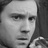

In [7]:
angry = list(data_dir.glob('angry/*'))
PIL.Image.open(str(angry[0]))

In [8]:
# batch size refers to the number of training examples utilised in one iteration. It will process 32 images at a time during training
batch_size = 32
#the height and width of the images will be restricted to 180
img_height, img_width = 180, 180

# Data Augmentation

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.2, 0.2)
])

# Load + Preprocess Data

In [10]:
#begins the creation of the training dataset using tensorflow's keras api
#image_dataset_from_directory is used to load and preprocess the images so that it is suitable to train a model
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, #80% of the data will be trained and 20% will be used to test it
    subset="training", #this specifies that it is for training
    seed=123, #random number generator to shuffle the dataset and create the split
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 35887 files belonging to 7 classes.
Using 28710 files for training.


In [11]:
#begins the creation of the validation dataset using tensorflow's keras api
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation", #this specifies that it is for validation
    seed=123, #this is the same to keep the split the same
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 35887 files belonging to 7 classes.
Using 7177 files for validation.


In [12]:
#gets the class names
class_names = train_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [13]:
# One-hot encode the labels
train_ds_one_hot = train_ds.unbatch().map(one_hot_encode).batch(32)
val_ds_one_hot = val_ds.unbatch().map(one_hot_encode).batch(32)

## Configure Dataset for Performance

In [14]:
#this optimises the performance of the training and validation datasets
#tf.data.AUTOTUNE prompts tensorflow to tune the buffering of elements in the data pipeline for optimal performance
#by setting it as a variable, it is being prepared to be used in the dataset operations that follow, allowing TensorFlow
#to dynamically adjust how much data to prefetch based on the current system's available resources
AUTOTUNE = tf.data.AUTOTUNE
#caches elements of train_ds. this loads images and labels into memory during the first epoch (iteration over dataset)
#this ensures them being reused in in subsequent epochs, speeding the training as I/O is reduced
#prefetch(buffer_size=AUTOTUNE) - prefetches the data; this is whilst the model is executing step 's' the input pipeline
#is reading step 's+1'
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Calculate Class Weights for Imbalanced Dataset

In [15]:
# Calculate class weights for imbalanced dataset
labels = []
for _, y in train_ds.unbatch():
    labels.append(y.numpy())

labels = np.array(labels)

In [16]:
unique_classes = np.unique(labels)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=labels)
class_weights = {class_id: weight for class_id, weight in zip(unique_classes, class_weights)}

In [17]:
class_weights

{0: 1.0341473957207694,
 1: 9.673180592991914,
 2: 1.0092097862767153,
 3: 0.5709910304091008,
 4: 0.8237454451553669,
 5: 0.8401123661262948,
 6: 1.2769080234833659}

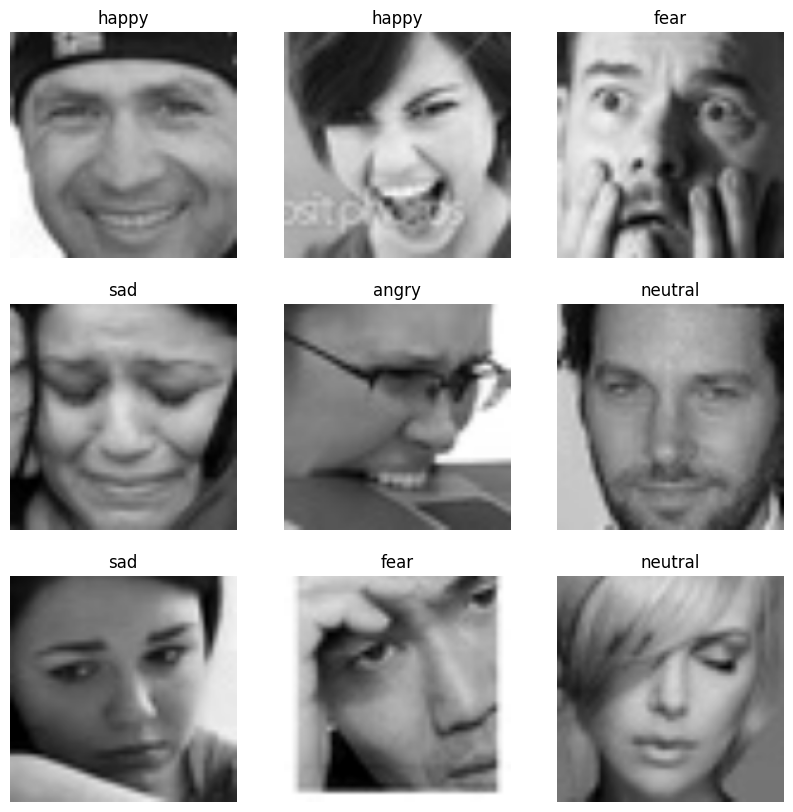

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [19]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


# Data Configuration

In [20]:
# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
# Normalization layer
normalization_layer = Rescaling(1./255)

In [22]:
# Apply normalization
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# Model Creation

## Define Model

In [23]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(7, activation='softmax'),  # Output layer for 7 classes
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

## Model Compilation

In [24]:
# Enable eager execution for debugging
tf.config.run_functions_eagerly(True)

In [25]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use categorical_crossentropy for one-hot labels
              metrics=['accuracy', 'Precision', 'Recall'])

In [26]:
# Callbacks (Early Stopping and Learning Rate Adjustment)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Model Training

In [27]:
# Print model summary to verify the final layer's configuration
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 20, 20, 128)      

In [28]:
try:
    history = model.fit(
        train_ds_one_hot,
        epochs=50,
        validation_data=val_ds_one_hot,
        callbacks=[early_stopping, lr_scheduler]
    )
except ValueError as e:
    print("Error during model training:", e)

Epoch 1/50


898/898 [==============================] - 754s 836ms/step - loss: 1.9006 - accuracy: 0.2239 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8249 - val_accuracy: 0.2516 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/50
898/898 [==============================] - 667s 743ms/step - loss: 1.8233 - accuracy: 0.2502 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8162 - val_accuracy: 0.2516 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/50
898/898 [==============================] - 1174s 1s/step - loss: 1.8161 - accuracy: 0.2502 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8148 - val_accuracy: 0.2516 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/50
898/898 [==============================] - 663s 739ms/step - loss: 1.8133 - accuracy: 0.2502 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.8145 - val_accuracy: 0.2516 - val_precision: 0.0000e+00 - val_recall: 0.0000e+0

In [ ]:
# Disable eager execution after debugging
tf.config.run_functions_eagerly(False)

# Evaluate the Model

In [ ]:
# Evaluate the model on the validation dataset
val_loss, val_accuracy, val_precision, val_recall = model.evaluate(val_ds_one_hot)

print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")

# Export Model as Tensorflow Lite Model

In [ ]:
# Load the SavedModel
model = tf.keras.models.load_model(r"C:\Users\faiza\Documents\Uni\Year 3\Final Project\Code")

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
# Save the TFLite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)